**4. CC_to_minF_scipy: 	Pruned_clique_complex -> Knill’s min F from scipy P**

Explore phase transitions for free energy by changing temperature and obtaining minimizing P.
-	Free energy vs temp for at least two probability strategies (scipy minimization and counting occurrences?)
-	If we may have bifurcation, one need to do several copies/simulations for the same network/brain
-	Compute this in a random graph, a scale free graph (similar size as brain)
-	Compute in a fmri based in mut info
-	Compute in structural connector (see dropbox Fernando sent - see Jupiter notes).

**Obtain the minimum free energy for a given clique complex**

In [4]:
# Import libraries
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pandas as pd

In [5]:
clique_complex_list = [[frozenset({1}), frozenset({2}), frozenset({1, 2})],
 [frozenset({2}), frozenset({3}), frozenset({2, 3})],
 [frozenset({1}), frozenset({4}), frozenset({6}), frozenset({1, 4, 6})]]

In [6]:
# Define shannon entropy function
def shannon_entropy(probabilities):
    # Remove any zero probabilities to avoid log(0) issues
    probabilities = probabilities[probabilities != 0]
    return -np.sum(probabilities * np.log2(probabilities))

# Internal energy function
def energy_function(x, Q):
    return x.T @ Q @ x

# Free energy function
def free_energy_function(x, Q, t):
    entropy_term = - np.sum(x * np.log2(np.maximum(x, 1e-10)))  # Avoid log(0), changed to np.log2 to improve speed.
    return t*(x.T @ Q @ x) - (1-t) * entropy_term

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse connectivity matrix
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix

# Find the minimum free energy for a given clique complex
def complete_f_generator_scipy(clique_complex, t):
    Q = generate_inverse_connectivity_matrix(clique_complex)[1]

    # Optimization settings
    cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(1e-10, None) for _ in range(len(Q))]
    x0 = np.full(len(Q), 1/len(Q))  # Initial guess

    # Store the latest optimized x0 and all free energies during minimization
    latest_x0 = None
    all_values = []

    # Callback function to collect values during minimization
    def callback(x):
        all_values.append(free_energy_function(x, Q, t))

    #for t in t_values:
    #    result = minimize(objective, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds)
    #    minimized_values.append(result.fun)
    #    latest_x0 = result.x  # Update the latest optimized x0

    result = minimize(free_energy_function, x0, args=(Q, t), method='SLSQP', constraints=cons, bounds=bounds, callback=callback)
    return [result.fun, result.x]

def complete_f_generator(clique_complex):
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_list = []
    temperature_list = np.arange(0, 1, 0.01)

    for temperature in temperature_list:
        f = complete_f_generator_scipy(clique_complex, temperature)[0]
        f_list.append(f)

    return f_list, temperature_list, min_energy_value, max_entropy_value

c:\Users\cyril\anaconda3\envs\TDA_brain\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


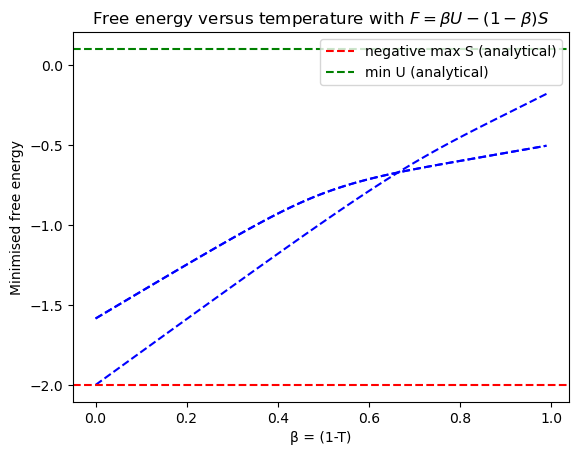

In [7]:
for i in range(0, len(clique_complex_list)):
    f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex_list[i])
    plt.plot(temperature_list, f_list, 'b--')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

In [8]:
import networkx as nx
import itertools

# Define a function to generate the clique complex from the list of cliques
def generate_clique_complex(cliques):
    clique_complex = []
    for clique in cliques:
        # Sort the nodes in the clique to maintain the order
        clique.sort()
        # Generate all possible subsets of nodes (simplices)
        for i in range(1, len(clique) + 1):
            simplices = [frozenset(sorted(subset)) for subset in itertools.combinations(clique, i)]
            clique_complex.extend(sorted(simplices))
    return clique_complex

# Generate a random graph
num_nodes = 10
probability = 0.3
dataset_size = 10
clique_complex_list = []

# Generate random clique_complex_list
for i in range(0, dataset_size):
    random_graph = nx.erdos_renyi_graph(num_nodes, probability)
    maximal_cliques = list(nx.find_cliques(random_graph))
    clique_complex = generate_clique_complex(maximal_cliques)
    clique_complex_list.append(clique_complex)

In [9]:
for i in range(0, len(clique_complex_list)):
    f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex_list[i])
    plt.plot(temperature_list, f_list, 'r--')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

LinAlgError: Singular matrix

# Phase transition with Pearson Correlation

In [10]:
# Import data
#matrix = np.genfromtxt('1000_Functional_Connectomes\Connectivity matrices\AveragedMatrix.txt')
matrix = np.genfromtxt('1000_Functional_Connectomes\Connectivity matrices\Baltimore_5568_connectivity_matrix_file.txt')

# Import external background functions
%run background_functions.py

<>:3: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
C:\Users\cyril\AppData\Local\Temp\ipykernel_30304\2570330229.py:3: SyntaxWarning: invalid escape sequence '\C'
  matrix = np.genfromtxt('1000_Functional_Connectomes\Connectivity matrices\Baltimore_5568_connectivity_matrix_file.txt')


In [11]:
# Define desired settings
cutoff=0.7 # Value between 0 and 1. Values below this value are set to zero. Becomes obsolete after including phase randomisation
max_dim=4

In [12]:
# Compute the clique complex and Euler Characteristic
%time euler_characteristic, clique_complex = compute_euler(matrix,cutoff,max_dim)

CPU times: total: 15.6 ms
Wall time: 5.19 ms


In [13]:
# Generate the connectivity matrix L from the clique complex
%time inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

CPU times: total: 62.5 ms
Wall time: 22.7 ms


In [14]:
%time f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(clique_complex)

CPU times: total: 6.41 s
Wall time: 23.4 s


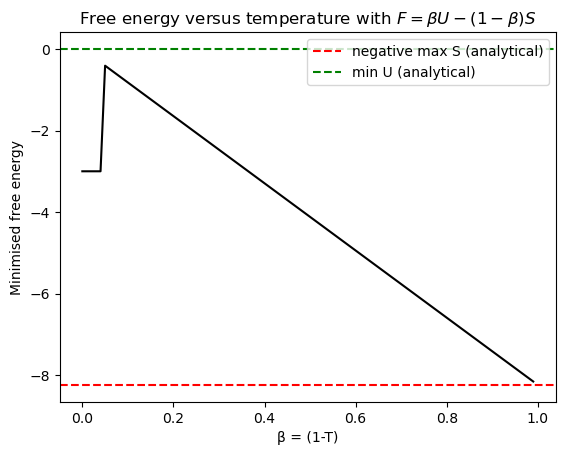

In [15]:
plt.plot(temperature_list, f_list, color='black')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

**For random clique_complex of same shape**

In [17]:
import random
import itertools

def count_frozenset_dimensions(frozenset_list):
    max_dimension = max(len(fs) for fs in frozenset_list)
    count_list = [0] * (max_dimension)
    for fs in frozenset_list:
        dimension = len(fs)
        if dimension > 0:
            count_list[dimension - 1] += 1
    return count_list

def generate_random_tuplets(input_list, length, dimension):
    input_list = list(itertools.chain.from_iterable(input_list))
    triplets = []
    # Generate all possible combinations of triplets
    all_triplets = itertools.combinations(input_list, dimension)
    all_triplets = list(all_triplets)  # Convert generator to list for random sampling
    
    # Randomly select 'length' number of triplets
    selected_triplets = random.sample(all_triplets, length)
    return selected_triplets

def generate_pair_combinations(triple_list, dimension):
    pair_combinations = []
    for triple in triple_list:
        pairs = list(itertools.combinations(triple, dimension))
        pair_combinations.extend(pairs)
    return pair_combinations

def generate_random_clique_complex(clique_amounts):
    input_list = [(i,) for i in range(1, clique_amounts[0] + 1)]
    clique_complex = []
    tuples = []

    for i in reversed(clique_amounts[1:]):
        dimension = clique_amounts.index(i)+1
        clique_amount = i-len(tuples)
        print(clique_amount)
        if clique_amount >= 0:
            tuples += generate_random_tuplets(input_list, clique_amount, dimension)
        clique_complex += tuples
        tuples = generate_pair_combinations(tuples, dimension-1)

    clique_complex += input_list
    #clique_complex = clique_complex[::-1]
    return clique_complex

REST_state = 'REST1'

# Read the CSV file and extract the first and second columns as lists
df_InfoCoho = pd.read_csv(f'InfoCoho_{REST_state}.txt', sep='\t')
ID_list = df_InfoCoho['identification_code'].tolist()
clique_complex_list = df_InfoCoho.iloc[:, 3].apply(eval).tolist()
clique_complex = clique_complex_list[1]

clique_amounts = count_frozenset_dimensions(clique_complex)
#clique_amounts = [177, 50, 9, 2]
print(clique_amounts)
random_clique_complex = generate_random_clique_complex(clique_amounts)
random_clique_complex = [frozenset(item) for item in random_clique_complex]
print(count_frozenset_dimensions(random_clique_complex))
print(len(random_clique_complex))
print(len(clique_complex))
print(random_clique_complex)

[20, 3, 26]
26
-75
[20, 78, 26]
124
49
[frozenset({2, 18, 5}), frozenset({8, 5, 15}), frozenset({9, 3, 20}), frozenset({11, 12, 15}), frozenset({17, 14, 7}), frozenset({2, 4, 20}), frozenset({10, 6, 7}), frozenset({9, 4, 14}), frozenset({8, 9, 19}), frozenset({18, 6, 15}), frozenset({17, 11, 4}), frozenset({17, 3, 6}), frozenset({12, 20, 14}), frozenset({18, 19, 13}), frozenset({16, 9, 6}), frozenset({17, 20, 6}), frozenset({2, 19, 6}), frozenset({2, 11, 12}), frozenset({16, 2, 3}), frozenset({11, 13, 6}), frozenset({17, 12, 6}), frozenset({9, 18, 13}), frozenset({3, 5, 7}), frozenset({2, 19, 7}), frozenset({17, 2, 4}), frozenset({17, 4, 20}), frozenset({2, 5}), frozenset({2, 18}), frozenset({18, 5}), frozenset({8, 5}), frozenset({5, 15}), frozenset({8, 15}), frozenset({9, 3}), frozenset({3, 20}), frozenset({9, 20}), frozenset({11, 12}), frozenset({11, 15}), frozenset({12, 15}), frozenset({14, 7}), frozenset({17, 7}), frozenset({17, 14}), frozenset({2, 4}), frozenset({2, 20}), frozense

In [18]:
random_clique_complex = [set(fs) for fs in random_clique_complex]
print(random_clique_complex)

[{2, 18, 5}, {8, 5, 15}, {9, 3, 20}, {11, 12, 15}, {17, 14, 7}, {2, 4, 20}, {10, 6, 7}, {9, 4, 14}, {8, 9, 19}, {18, 6, 15}, {17, 11, 4}, {17, 3, 6}, {12, 20, 14}, {18, 19, 13}, {16, 9, 6}, {17, 20, 6}, {2, 19, 6}, {2, 11, 12}, {16, 2, 3}, {11, 13, 6}, {17, 12, 6}, {9, 18, 13}, {3, 5, 7}, {2, 19, 7}, {17, 2, 4}, {17, 4, 20}, {2, 5}, {2, 18}, {18, 5}, {8, 5}, {5, 15}, {8, 15}, {9, 3}, {3, 20}, {9, 20}, {11, 12}, {11, 15}, {12, 15}, {14, 7}, {17, 7}, {17, 14}, {2, 4}, {2, 20}, {4, 20}, {6, 7}, {10, 6}, {10, 7}, {9, 4}, {4, 14}, {9, 14}, {8, 9}, {8, 19}, {9, 19}, {6, 15}, {18, 6}, {18, 15}, {11, 4}, {17, 4}, {17, 11}, {3, 6}, {17, 3}, {17, 6}, {12, 14}, {12, 20}, {20, 14}, {18, 13}, {19, 13}, {18, 19}, {9, 6}, {16, 6}, {16, 9}, {17, 6}, {20, 6}, {17, 20}, {2, 6}, {2, 19}, {19, 6}, {2, 11}, {2, 12}, {11, 12}, {2, 3}, {16, 2}, {16, 3}, {11, 6}, {13, 6}, {11, 13}, {12, 6}, {17, 6}, {17, 12}, {9, 13}, {9, 18}, {18, 13}, {3, 5}, {3, 7}, {5, 7}, {2, 7}, {2, 19}, {19, 7}, {2, 4}, {17, 2}, {17, 4

In [22]:
%time f_list, temperature_list, min_energy_value, max_entropy_value = complete_f_generator(random_clique_complex)

LinAlgError: Singular matrix

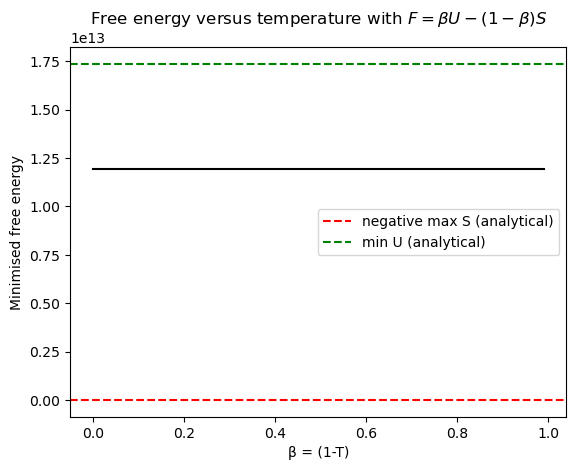

In [21]:
plt.plot(temperature_list, f_list, color='black')
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-max_entropy_value, color='r', linestyle='--', label='negative max S (analytical)')
plt.axhline(y=min_energy_value, color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()

In [23]:
# Genrate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):
    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    np.savetxt('matrix.txt', matrix, fmt='%d')
    #plt.imshow(matrix)
    #plt.show()
    # Compute the inverse connectivity matrix
    #print(np.linalg.det(matrix))
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return matrix, inverse_connectivity_matrix


# Choose desired settings
REST_state = 'REST1'

# Read the CSV file and extract the first and second columns as lists
df_InfoCoho = pd.read_csv(f'InfoCoho_{REST_state}.txt', sep='\t')
ID_list = df_InfoCoho['identification_code'].tolist()
clique_complex_list = df_InfoCoho.iloc[:, 3].apply(eval).tolist()
clique_complex = clique_complex_list[1]
print(len(clique_complex))

clique_complex_list = [[frozenset({1}), frozenset({2}), frozenset({1, 2})],
 [frozenset({2}), frozenset({3}), frozenset({3, 2})],
 [frozenset({1}), frozenset({4}), frozenset({6}), frozenset({4, 1, 6})]]
#clique_complex = clique_complex_list[2]
print(count_frozenset_dimensions(clique_complex))
clique_complex = [set(fs) for fs in clique_complex]
clique_complex = clique_complex[::-1]
print(clique_complex)
inverse_matrix = generate_inverse_connectivity_matrix(clique_complex)[1]

49
[20, 3, 26]
[{18, 19, 20}, {17, 19, 20}, {17, 18, 20}, {19, 20, 14}, {18, 20, 14}, {17, 20, 14}, {9, 12, 15}, {12, 15, 7}, {11, 12, 7}, {9, 15, 7}, {9, 12, 7}, {19, 20, 6}, {20, 6, 14}, {4, 12, 15}, {9, 4, 15}, {9, 4, 12}, {4, 15, 7}, {4, 12, 7}, {3, 15, 7}, {1, 12, 15}, {1, 9, 15}, {1, 12, 9}, {1, 15, 7}, {1, 9, 7}, {1, 4, 15}, {1, 4, 9}, {18, 20}, {18, 19}, {17, 19}, {20}, {19}, {18}, {17}, {16}, {15}, {14}, {13}, {12}, {11}, {10}, {9}, {8}, {7}, {6}, {5}, {4}, {3}, {2}, {1}]


LinAlgError: Singular matrix

# WHYYYYYYYY

In [24]:
Real_data_complex = [{18, 19, 20}, {17, 19, 20}, {17, 18, 20}, {19, 20, 14}, {18, 20, 14}, {17, 20, 14}, {9, 12, 15}, {12, 15, 7}, {11, 12, 7}, {9, 15, 7}, {9, 12, 7}, {19, 20, 6}, {20, 6, 14}, {4, 12, 15}, {9, 4, 15}, {9, 4, 12}, {4, 15, 7}, {4, 12, 7}, {3, 15, 7}, {1, 12, 15}, {1, 9, 15}, {1, 12, 9}, {1, 15, 7}, {1, 9, 7}, {1, 4, 15}, {1, 4, 9}, {18, 20}, {18, 19}, {17, 19}, {20}, {19}, {18}, {17}, {16}, {15}, {14}, {13}, {12}, {11}, {10}, {9}, {8}, {7}, {6}, {5}, {4}, {3}, {2}, {1}]
Random_data_complex_singular = [{11, 4, 20}, {2, 18, 5}, {9, 13, 6}, {11, 13, 14}, {1, 2, 15}, {2, 19, 14}, {16, 10, 12}, {2, 10, 15}, {17, 18, 11}, {19, 4, 20}, {17, 18, 3}, {8, 10, 13}, {1, 5, 7}, {16, 19, 14}, {16, 2, 15}, {16, 15, 7}, {9, 11, 7}, {8, 10, 6}, {17, 19, 20}, {9, 4, 14}, {9, 13, 17}, {2, 19, 5}, {8, 11, 6}, {12, 13, 15}, {16, 10, 4}, {11, 12, 7}, {11, 4}, {4, 20}, {11, 20}, {2, 5}, {2, 18}, {18, 5}, {9, 6}, {13, 6}, {9, 13}, {11, 13}, {11, 14}, {13, 14}, {1, 2}, {1, 15}, {2, 15}, {2, 14}, {2, 19}, {19, 14}, {10, 12}, {16, 10}, {16, 12}, {2, 10}, {2, 15}, {10, 15}, {17, 11}, {18, 11}, {17, 18}, {19, 4}, {4, 20}, {19, 20}, {17, 3}, {18, 3}, {17, 18}, {8, 10}, {8, 13}, {10, 13}, {1, 5}, {1, 7}, {5, 7}, {16, 14}, {19, 14}, {16, 19}, {2, 15}, {16, 2}, {16, 15}, {15, 7}, {16, 7}, {16, 15}, {9, 7}, {11, 7}, {9, 11}, {8, 6}, {10, 6}, {8, 10}, {17, 19}, {17, 20}, {19, 20}, {9, 4}, {4, 14}, {9, 14}, {9, 13}, {9, 17}, {17, 13}, {2, 5}, {2, 19}, {19, 5}, {8, 6}, {11, 6}, {8, 11}, {12, 13}, {12, 15}, {13, 15}, {10, 4}, {16, 4}, {16, 10}, {11, 7}, {12, 7}, {11, 12}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]
Random_data_complex_unimodular = [{1, 2, 18}, {16, 20, 6}, {8, 5, 14}, {8, 2, 20}, {20, 6, 14}, {9, 11, 4}, {8, 19, 7}, {17, 3, 20}, {15, 6, 7}, {17, 4, 15}, {18, 12, 5}, {19, 3, 14}, {9, 4, 15}, {1, 12, 6}, {18, 11, 6}, {8, 3, 12}, {18, 12, 13}, {17, 10, 11}, {1, 3, 4}, {1, 18, 19}, {1, 12, 15}, {10, 20, 15}, {16, 5, 15}, {11, 12, 7}, {11, 13, 15}, {17, 12, 20}, {1, 2}, {1, 18}, {2, 18}, {16, 6}, {20, 6}, {16, 20}, {8, 5}, {5, 14}, {8, 14}, {8, 2}, {2, 20}, {8, 20}, {6, 14}, {20, 6}, {20, 14}, {9, 4}, {11, 4}, {9, 11}, {8, 7}, {19, 7}, {8, 19}, {17, 3}, {3, 20}, {17, 20}, {6, 7}, {6, 15}, {15, 7}, {4, 15}, {17, 4}, {17, 15}, {12, 5}, {18, 5}, {18, 12}, {3, 14}, {19, 3}, {19, 14}, {9, 4}, {4, 15}, {9, 15}, {1, 6}, {1, 12}, {12, 6}, {11, 6}, {18, 6}, {18, 11}, {8, 3}, {3, 12}, {8, 12}, {12, 13}, {18, 12}, {18, 13}, {10, 11}, {17, 10}, {17, 11}, {1, 3}, {1, 4}, {3, 4}, {1, 18}, {1, 19}, {18, 19}, {1, 12}, {1, 15}, {12, 15}, {10, 15}, {10, 20}, {20, 15}, {5, 15}, {16, 5}, {16, 15}, {11, 7}, {12, 7}, {11, 12}, {11, 13}, {11, 15}, {13, 15}, {17, 12}, {12, 20}, {17, 20}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]

In [25]:
# Import libraries
import numpy as np

# Generate the matrix L^-1 as required by Knill
def generate_inverse_connectivity_matrix(clique_complex):

    # Initialize the matrix
    size = len(clique_complex)
    matrix = np.zeros((size, size))

    # Fill the matrix
    for i in range(0, len(clique_complex)):
        for j in range(0, len(clique_complex)):
            if clique_complex[i].intersection(clique_complex[j]):
                matrix[i, j] = 1

    # Compute the inverse
    inverse_connectivity_matrix = np.linalg.inv(matrix)

    return inverse_connectivity_matrix


# Two clique complexes with 20 nodes, 78 edges and 26 triangles. The pairs are generated from random combinations of the nodes and the triangles from random combinations of the pairs.
Random_data_complex_singular = [{11, 4, 20}, {2, 18, 5}, {9, 13, 6}, {11, 13, 14}, {1, 2, 15}, {2, 19, 14}, {16, 10, 12}, {2, 10, 15}, {17, 18, 11}, {19, 4, 20}, {17, 18, 3}, {8, 10, 13}, {1, 5, 7}, {16, 19, 14}, {16, 2, 15}, {16, 15, 7}, {9, 11, 7}, {8, 10, 6}, {17, 19, 20}, {9, 4, 14}, {9, 13, 17}, {2, 19, 5}, {8, 11, 6}, {12, 13, 15}, {16, 10, 4}, {11, 12, 7}, {11, 4}, {4, 20}, {11, 20}, {2, 5}, {2, 18}, {18, 5}, {9, 6}, {13, 6}, {9, 13}, {11, 13}, {11, 14}, {13, 14}, {1, 2}, {1, 15}, {2, 15}, {2, 14}, {2, 19}, {19, 14}, {10, 12}, {16, 10}, {16, 12}, {2, 10}, {2, 15}, {10, 15}, {17, 11}, {18, 11}, {17, 18}, {19, 4}, {4, 20}, {19, 20}, {17, 3}, {18, 3}, {17, 18}, {8, 10}, {8, 13}, {10, 13}, {1, 5}, {1, 7}, {5, 7}, {16, 14}, {19, 14}, {16, 19}, {2, 15}, {16, 2}, {16, 15}, {15, 7}, {16, 7}, {16, 15}, {9, 7}, {11, 7}, {9, 11}, {8, 6}, {10, 6}, {8, 10}, {17, 19}, {17, 20}, {19, 20}, {9, 4}, {4, 14}, {9, 14}, {9, 13}, {9, 17}, {17, 13}, {2, 5}, {2, 19}, {19, 5}, {8, 6}, {11, 6}, {8, 11}, {12, 13}, {12, 15}, {13, 15}, {10, 4}, {16, 4}, {16, 10}, {11, 7}, {12, 7}, {11, 12}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]
Random_data_complex_unimodular = [{1, 2, 18}, {16, 20, 6}, {8, 5, 14}, {8, 2, 20}, {20, 6, 14}, {9, 11, 4}, {8, 19, 7}, {17, 3, 20}, {15, 6, 7}, {17, 4, 15}, {18, 12, 5}, {19, 3, 14}, {9, 4, 15}, {1, 12, 6}, {18, 11, 6}, {8, 3, 12}, {18, 12, 13}, {17, 10, 11}, {1, 3, 4}, {1, 18, 19}, {1, 12, 15}, {10, 20, 15}, {16, 5, 15}, {11, 12, 7}, {11, 13, 15}, {17, 12, 20}, {1, 2}, {1, 18}, {2, 18}, {16, 6}, {20, 6}, {16, 20}, {8, 5}, {5, 14}, {8, 14}, {8, 2}, {2, 20}, {8, 20}, {6, 14}, {20, 6}, {20, 14}, {9, 4}, {11, 4}, {9, 11}, {8, 7}, {19, 7}, {8, 19}, {17, 3}, {3, 20}, {17, 20}, {6, 7}, {6, 15}, {15, 7}, {4, 15}, {17, 4}, {17, 15}, {12, 5}, {18, 5}, {18, 12}, {3, 14}, {19, 3}, {19, 14}, {9, 4}, {4, 15}, {9, 15}, {1, 6}, {1, 12}, {12, 6}, {11, 6}, {18, 6}, {18, 11}, {8, 3}, {3, 12}, {8, 12}, {12, 13}, {18, 12}, {18, 13}, {10, 11}, {17, 10}, {17, 11}, {1, 3}, {1, 4}, {3, 4}, {1, 18}, {1, 19}, {18, 19}, {1, 12}, {1, 15}, {12, 15}, {10, 15}, {10, 20}, {20, 15}, {5, 15}, {16, 5}, {16, 15}, {11, 7}, {12, 7}, {11, 12}, {11, 13}, {11, 15}, {13, 15}, {17, 12}, {12, 20}, {17, 20}, {1}, {2}, {3}, {4}, {5}, {6}, {7}, {8}, {9}, {10}, {11}, {12}, {13}, {14}, {15}, {16}, {17}, {18}, {19}, {20}]

# Compute inverse connectivity matrix
print(count_frozenset_dimensions(Random_data_complex_unimodular))
inverse_connectivity_matrix = generate_inverse_connectivity_matrix(Random_data_complex_unimodular)
print(inverse_connectivity_matrix)

print(count_frozenset_dimensions(Random_data_complex_singular))
inverse_connectivity_matrix = generate_inverse_connectivity_matrix(Random_data_complex_singular)
print(inverse_connectivity_matrix)

[20, 78, 26]
[[ 4.41270312e+00 -6.17880764e+00 -5.46918490e+01 ...  1.28534346e-01
  -9.36047106e-15 -8.65626172e-02]
 [-8.28433332e+00  1.77943226e+01  4.19505999e+00 ...  2.97332651e-01
   1.15237615e-14 -1.28067493e+00]
 [-7.49080845e+00 -9.61287646e+00 -2.38948829e+01 ... -2.82186011e-01
  -5.10702591e-16  9.95334091e-01]
 ...
 [-1.96537661e+00 -5.80462555e+00 -1.98594321e+00 ... -1.91815762e+00
  -6.69934300e-17 -1.76170796e-01]
 [-7.90673734e-01 -9.00905636e-01 -1.06531933e+00 ... -9.60898448e-02
  -2.00000000e+00  3.48233698e-01]
 [ 1.50405197e+00 -8.81521163e-01 -7.19580537e-01 ... -9.53168488e-02
   3.10256204e-15 -2.82106417e+00]]
[20, 78, 26]


LinAlgError: Singular matrix